In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD

x_test = np.load('/home/jovyan/MQTTset/x_test.npy')
x_train = np.load('/home/jovyan/MQTTset/x_train.npy')
x_val = np.load('/home/jovyan/MQTTset/x_val.npy')
y_test = np.load('/home/jovyan/MQTTset/y_test.npy')
y_train = np.load('/home/jovyan/MQTTset/y_train.npy')
y_val = np.load('/home/jovyan/MQTTset/y_val.npy')

2024-01-30 06:13:06.449625: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 06:13:06.623585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 06:13:06.623705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 06:13:06.626680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 06:13:06.652788: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 06:13:06.654883: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
input_shape = x_train.shape[1:]
num_classes = len(np.unique(y_train))


dnn_model = Sequential()
dnn_model.add(Input(shape=input_shape))
dnn_model.add(Dense(units=30, activation='relu'))
dnn_model.add(Dense(units=20, activation='relu'))
dnn_model.add(Dense(units=num_classes, activation='softmax'))

opt = SGD(lr=0.01)

dnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
hist = dnn_model.fit(x_train, y_train, epochs=2, batch_size=64,
                     validation_data=(x_val, y_val),
                     callbacks=[early_stopping])

test_loss, test_acc = dnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

y_hat = dnn_model.predict(x_test)
y_hat = np.argmax(y_hat, axis=-1)

2024-01-30 06:13:13.913915: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/2
112318/112318 [==============================] - 244s 2ms/step - loss: 311.0999 - accuracy: 0.9877 - val_loss: 0.0800 - val_accuracy: 0.9870
Epoch 2/2
113262/113262 [==============================] - 180s 2ms/step - loss: 0.0794 - accuracy: 0.9871
Test accuracy: 0.9871489405632019
113262/113262 [==============================] - 160s 1ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113262/113262 [==============================] - 161s 1ms/step
FPR: [0.00000000e+00 5.29943332e-06 0.00000000e+00 9.37705182e-01
 0.00000000e+00 0.00000000e+00]
TPR: [0.        0.0786652 0.        1.        0.        0.       ]
FNR: [1.        0.9213348 1.        0.        1.        1.       ]
TNR: [1.         0.9999947  1.         0.06229482 1.         1.        ]
Precision: 0.33016671531572356
Accuracy: 0.9871489248050556
F1-score: 0.1898868087433345
AUC: 0.5118099043695188
FPR: 0.15628508026748014
tpr: 0.17977753324632562
fnr: 0.8202224667536745
tnr: 0.8437149197325198


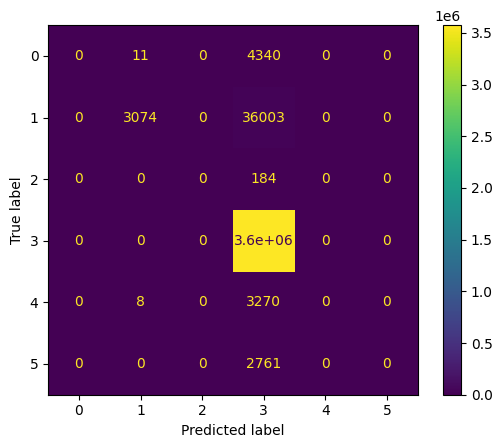

In [4]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score



conf_matrix = confusion_matrix(y_test, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_hat, average='macro')
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='macro')
auc = roc_auc_score(y_test, dnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "dnn",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/MQTTset/model.csv", mode='a', index=False)